In [ ]:
!pip install ydata-synthetic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 58.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.7/280.7 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.3
    Uninstalling typing_extensions-4.6.3:
      Successfully uninstalled typing_extensions-4.6.3
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.20.1
    Uninstalling tensorflow-probability-0.20.1:
      Successfully uninstalled tensorflow-probability-0.20.1
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  A

In [ ]:
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from datetime import timedelta

from ydata_synthetic.preprocessing.timeseries.utils import real_data_loading
from ydata_synthetic.synthesizers import ModelParameters
from ydata_synthetic.synthesizers import TrainParameters
from ydata_synthetic.preprocessing.timeseries import processed_stock
from ydata_synthetic.synthesizers.timeseries.timegan.model import TimeGAN

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
#Specific to TimeGANs
seq_len=24
n_seq = 4
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4
epochs = 5000

num_cols = ['내부온도관측치', '내부습도관측치', 'ec관측치', 'co2관측치']

gan_args = ModelParameters(batch_size=batch_size,
                           lr=learning_rate,
                           noise_dim=noise_dim,
                           layers_dim=dim,
                           latent_dim=hidden_dim,
                           gamma=gamma)
train_args = TrainParameters(sequence_length=seq_len,
                             number_sequences=n_seq,
                             epochs=epochs)

In [ ]:
def make_traindata_timegan(input_dir_list):
  train = pd.DataFrame()
  for i in range(len(input_dir_list)):
    train_df = pd.read_csv(input_dir_list[i])
    train = pd.concat([train, train_df])
  train['obs_time'] = pd.to_datetime(train['obs_time'])
  train['datetime'] = train['obs_time'] + train['DAT'].apply(lambda x: timedelta(days=x))

  # 이상값 처리
  # 내부온도,습도=0 -> 평균으로 대체
  train.loc[train['내부온도관측치'] == 0, '내부온도관측치'] = 28.479124
  train.loc[train['내부습도관측치'] == 0, '내부습도관측치'] = 53.469956

  # column 삭제
  col_names = ['내부온도관측치', '내부습도관측치', 'ec관측치', 'co2관측치']
  train = train[['datetime'] + col_names]

  return train

In [ ]:
input_dir_list = sorted(glob('/kaggle/input/dataset/train_input/CASE_20.csv'))
train_df = make_traindata_timegan(input_dir_list)

train_df = train_df.drop(columns='datetime')
train_data = real_data_loading(train_df.values, seq_len=seq_len)
print(len(train_data), train_data[0].shape)

648 (24, 4)


/tmp/ipykernel_28/2948948464.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train['obs_time'] = pd.to_datetime(train['obs_time'])


In [ ]:
if path.exists('synthesizer_env.pkl'):
    synth = TimeGAN.load('synthesizer_env.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args)
    synth.fit(data=train_df, num_cols=num_cols, train_arguments=train_args)
    synth.save('synthesizer_env.pkl')

A DataProcessor is not available for the TimeGAN.


Joint networks training: 100%|██████████| 5000/5000 [1:04:40<00:00,  1.29it/s]
/opt/conda/lib/python3.10/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [ ]:
synth_data = synth.sample(len(train_data))
print(len(synth_data), synth_data[0].shape)

648 (24, 4)


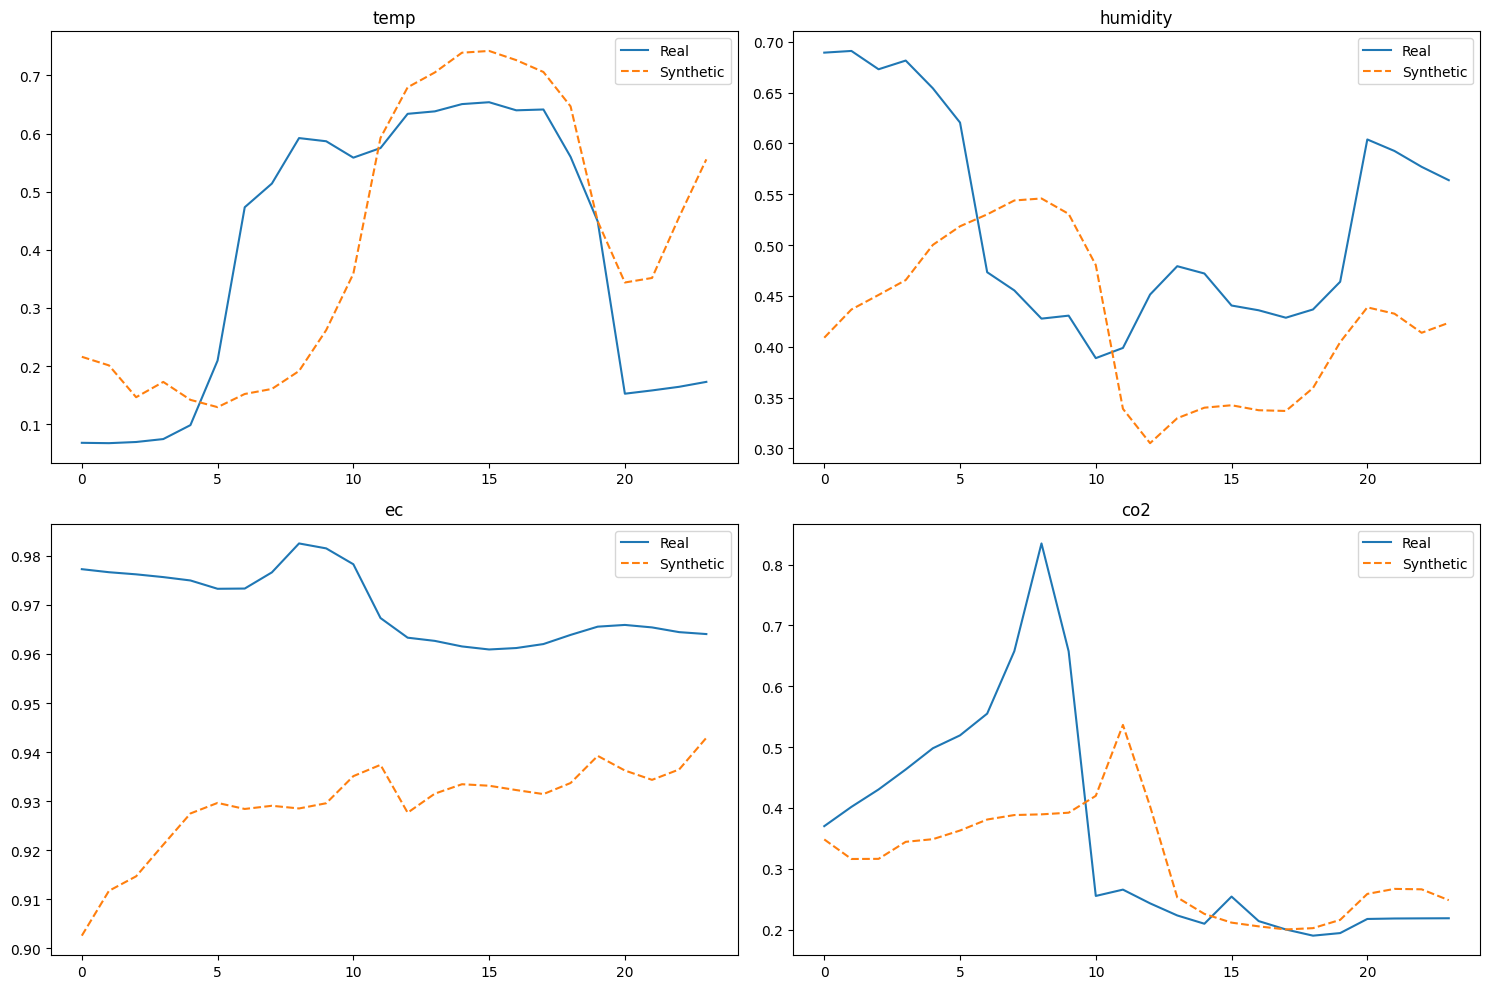

In [ ]:
#Reshaping the data
cols = ['내부온도관측치', '내부습도관측치', 'ec관측치', 'co2관측치']
titles = ['temp', 'humidity', 'ec', 'co2']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(train_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': train_data[obs][:, j],
                   'Synthetic': synth_data[obs].iloc[:, j]})
    df.plot(ax=axes[j],
            title = titles[j],
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()